In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display
%matplotlib inline

In [2]:
df = pd.read_csv("GBPINR=X.csv") 

In [3]:
df['return'] = df['Adj Close'] - df['Adj Close'].shift(1)
return_range = df['return'].max() - df['return'].min()
df['return'] = df['return'] / return_range

In [4]:
df['label'] = df['return'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
df.dropna(inplace=True)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,return,label
3838,1/29/21,100.120110,100.197548,99.593643,100.120110,100.120110,0.0,0.026024,0
3839,2/1/21,99.882317,100.475883,99.882317,99.963753,99.963753,0.0,-0.013699,1
3840,2/2/21,99.991524,100.354309,99.345207,99.991524,99.991524,0.0,0.002433,0
3841,2/3/21,99.637161,99.826256,99.347580,99.642159,99.642159,0.0,-0.030608,0
3842,2/4/21,99.430702,99.684097,98.883904,99.587402,99.587402,0.0,-0.004797,0


In [5]:
n_features = 60 

train_x = np.array([]).reshape([-1,n_features])
train_y = np.array([]).reshape([-1,1])
for index, row in df.iterrows():
    i = df.index.get_loc(index)
    if i < n_features:
        continue
    _x = np.array(df[i-n_features+1:i+1]['return']).T.reshape([1, -1])
    _y = df.iloc[i]['label']
    train_x = np.vstack((train_x, _x))
    train_y = np.vstack((train_y, _y))
train_y = train_y.reshape([-1])
print(train_x.shape)
print(train_y.shape)
print('%% of Class0 : %f' % (np.count_nonzero(train_y == 0)/float(len(train_y))))
print('%% of Class1 : %f' % (np.count_nonzero(train_y == 1)/float(len(train_y))))

(3715, 60)
(3715,)
% of Class0 : 0.497174
% of Class1 : 0.502826


In [6]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=10000)

train_len = int(len(train_x) * 0.95)
clf.fit(train_x[:train_len], train_y[:train_len])

accuracy = clf.score(train_x[train_len:], train_y[train_len:])

print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.510753


Enter value of equity:1500


,return,label,pred,won,pnl,equity
180,0.297036,1.0,1.0,True,445.5540,13512.4800
181,-0.156357,0.0,1.0,False,-234.5355,13277.9445
182,0.027771,1.0,0.0,False,-41.6565,13236.2880
183,-0.349365,0.0,1.0,False,-524.0475,12712.2405
184,-0.054757,0.0,0.0,True,82.1355,12794.3760


,return,label,pred,won,pnl,equity
0,0.033798,1.0,1.0,True,50.6970,50.6970
1,0.159653,1.0,1.0,True,239.4795,290.1765
2,-0.057373,0.0,1.0,False,-86.0595,204.1170
3,0.972511,1.0,0.0,False,-1458.7665,-1254.6495
4,-0.330849,0.0,0.0,True,496.2735,-758.3760


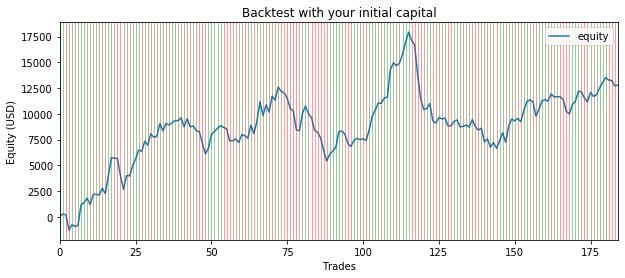

In [7]:
pred = clf.predict(train_x[train_len:])


# Calculate equity..

contracts  = int(input("Enter value of equity:"))
commission = 0.0


df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['return'])
df_trade['label']  = train_y[train_len:]
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade['return'] = df_trade['return'].shift(-1) * return_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission
    else:
        return -abs(row['return'])*contracts - commission

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='equity', figsize=(10,4), title='Backtest with your initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')
display(df_trade.head())

Net Profit            : £12794.38
Number Winning Trades : 95
Number Losing Trades  : 90
Percent Profitable    : 51.35%
Avg Win Trade         : £674.974
Avg Los Trade         : £-570.313
Largest Win Trade     : £2660.465
Largest Los Trade     : £-2922.581
Profit Factor         : 1.25


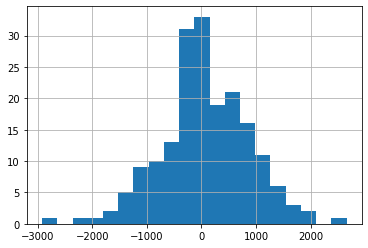

In [8]:
# Calculate summary of trades

n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Net Profit            : £%.2f" % df_trade.tail(1)['equity'])
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : £%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : £%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : £%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : £%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))

df_trade['pnl'].hist(bins=20)